<a href="https://colab.research.google.com/github/saichandrapandraju/TF-Developer/blob/main/3.%20NLP/3.%20Embedd_LSTM_CNN_Overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 18 08:33:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import csv
from tqdm.notebook import tqdm
import tensorflow as tf
tf.random.set_seed(333)
import numpy as np
np.random.seed(333)
import matplotlib.pyplot as plt
import random
random.seed(333)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2021-04-18 08:33:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.7.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   171MB/s    in 1.3s    

2021-04-18 08:33:24 (171 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
data = []
with open('/tmp/training_cleaned.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  for row in tqdm(csv_reader):
    data.append(row)

In [5]:
random.shuffle(data)

In [6]:
sentences, labels = [], []
for sample in tqdm(data):
  sentences.append(sample[5])
  lbl = int(sample[0])
  if lbl == 0: labels.append(0)    # unique labels in corpus are 0 and 4
  else : labels.append(1)
  

In [7]:
## test pipeline on small data
size = int(len(sentences) * 1)
sentences = sentences[:size]
labels = labels[:size]

In [8]:
size

1600000

In [9]:
labels.count(0)

800000

In [10]:
labels.count(1)

800000

In [11]:
train_size = int(len(sentences) * 0.9)
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

val_sentences = sentences[train_size:]
val_labels = labels[train_size:]

In [12]:
tok = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')

In [13]:
tok.fit_on_texts(train_sentences)

In [14]:
word_index = tok.word_index

In [15]:
len(word_index)

643940

In [16]:
vocab_size = len(word_index)

In [17]:
train_sequences = tok.texts_to_sequences(train_sentences)
max_len = []
for i in tqdm(train_sequences):
  max_len.append(len(i))

In [18]:
max(max_len)

118

In [19]:
inp_length = 64

In [20]:
train_inp = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=inp_length, padding='post', truncating='post')

In [21]:
train_labels = np.array(train_labels)

In [22]:
val_sequences = tok.texts_to_sequences(val_sentences)
val_inp = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=inp_length, padding='post', truncating='post')

In [23]:
val_labels = np.array(val_labels)

In [24]:
train_inp.shape, train_labels.shape, val_inp.shape, val_labels.shape

((1440000, 64), (1440000,), (160000, 64), (160000,))

In [25]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/test-for-future/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2021-04-18 08:34:30--  https://storage.googleapis.com/test-for-future/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   252MB/s    in 1.3s    

2021-04-18 08:34:32 (252 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [26]:
# read GloVe file and form word to embed dict
word_embeddings_glove = {}
with open('/tmp/glove.6B.100d.txt') as f:
  for line in tqdm(f):
    line_list = line.split()
    word = line_list[0]
    embeddings = np.asarray(line_list[1:] , dtype='float32')
    word_embeddings_glove[word] = embeddings

In [27]:
word_embeddings_glove['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [28]:
## form embedding matrix for our word corpus
## word_index will have keys starting from 1 and don't have zeros. while creating emb_matrix, give +1 so that it won't give index error
# eg. word_index have 1 to 1000, if we create np.zeros with 1000 as 1st dimension, and it expects inputs from 0 to 999 and as we reach 1000th in our word_index,
## it'll throw error. so if we give 1000+1 as 1st dimension, though we won't use 0, it'll not throw any error

emb_dimension = 100   ## because glove vectors are 100 dimensional
embedding_matrix = np.zeros((vocab_size+1, emb_dimension))
for word, i in tqdm(word_index.items()):
  emb_vector = word_embeddings_glove.get(word)
  if emb_vector is not None:
    embedding_matrix[i] = emb_vector

In [29]:
print(embedding_matrix.shape)

(643941, 100)


In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train_'+string, 'val_'+string])
  plt.show()

model 1

In [ ]:
# create a model with non-trainable embedding layer
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size+1, emb_dimension, input_length=inp_length, weights=[embedding_matrix], trainable=False),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           12816000  
_________________________________________________________________
dense (Dense)                (None, 64, 32)            3232      
_________________________________________________________________
dense_1 (Dense)              (None, 64, 1)             33        
Total params: 12,819,265
Trainable params: 3,265
Non-trainable params: 12,816,000
_________________________________________________________________


In [ ]:
history = model.fit(train_inp, train_labels, batch_size=128, epochs=20, validation_data=(val_inp, val_labels), validation_batch_size=128, verbose=1)

Epoch 1/20
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6912 - accuracy: 0.5132 - val_loss: 0.6893 - val_accuracy: 0.5164
Epoch 2/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6891 - accuracy: 0.5188 - val_loss: 0.6888 - val_accuracy: 0.5167
Epoch 3/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6888 - accuracy: 0.5179 - val_loss: 0.6886 - val_accuracy: 0.5171
Epoch 4/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6887 - accuracy: 0.5187 - val_loss: 0.6883 - val_accuracy: 0.5174
Epoch 5/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6885 - accuracy: 0.5184 - val_loss: 0.6882 - val_accuracy: 0.5176
Epoch 6/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6883 - accuracy: 0.5179 - val_loss: 0.6884 - val_accuracy: 0.5173
Epoch 7/20
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6883 - accuracy: 0.5174 - val_loss: 0.6882 - val_accuracy:

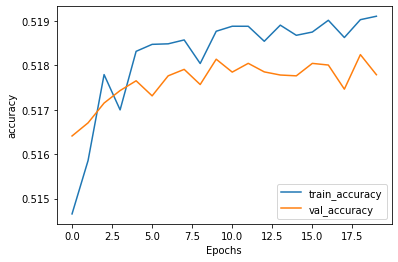

In [ ]:
plot_graphs(history, "accuracy")

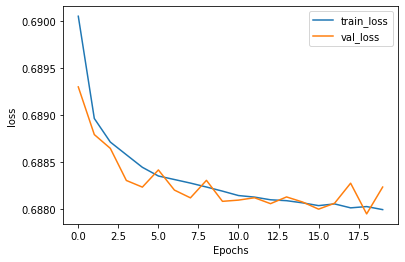

In [ ]:
plot_graphs(history, "loss")

**Model is not learning anything. So adding a bit more complexity.**

model 2

In [ ]:
tf.keras.backend.clear_session()
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, emb_dimension, input_length=inp_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           12816000  
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64, 64)            41216     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64, 32)            12416     
_________________________________________________________________
dense (Dense)                (None, 64, 1)             33        
Total params: 13,268,513
Trainable params: 452,513
Non-trainable params: 12,816,000
______________________________________

In [ ]:
history2 = model2.fit(train_inp, train_labels, batch_size=256, epochs=20, validation_data=(val_inp, val_labels), validation_batch_size=256)

Epoch 1/20
563/563 [==============================] - 33s 45ms/step - loss: 0.5890 - accuracy: 0.6823 - val_loss: 0.5119 - val_accuracy: 0.7485
Epoch 2/20
563/563 [==============================] - 22s 39ms/step - loss: 0.4993 - accuracy: 0.7572 - val_loss: 0.4683 - val_accuracy: 0.7755
Epoch 3/20
563/563 [==============================] - 22s 39ms/step - loss: 0.4705 - accuracy: 0.7761 - val_loss: 0.4568 - val_accuracy: 0.7807
Epoch 4/20
563/563 [==============================] - 22s 39ms/step - loss: 0.4496 - accuracy: 0.7875 - val_loss: 0.4502 - val_accuracy: 0.7846
Epoch 5/20
563/563 [==============================] - 22s 40ms/step - loss: 0.4284 - accuracy: 0.8006 - val_loss: 0.4443 - val_accuracy: 0.7872
Epoch 6/20
563/563 [==============================] - 23s 40ms/step - loss: 0.4116 - accuracy: 0.8115 - val_loss: 0.4344 - val_accuracy: 0.7956
Epoch 7/20
563/563 [==============================] - 22s 40ms/step - loss: 0.3941 - accuracy: 0.8205 - val_loss: 0.4391 - val_accuracy:

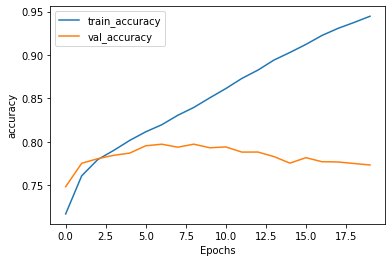

In [ ]:
plot_graphs(history2, "accuracy")

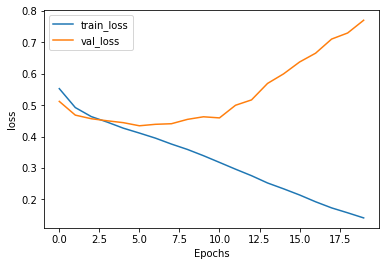

In [ ]:
plot_graphs(history2, "loss")

**Started overfitting ~7th epoch. But feels like train metrics can be improved if added a bit more cimplexity and train for a bit longer.**

model 3

In [ ]:
tf.keras.backend.clear_session()
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, emb_dimension, input_length=inp_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           12816000  
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 512)           788480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 128)           164352    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 15, 64)            4

In [ ]:
history3 = model3.fit(train_inp, train_labels, batch_size=256, epochs=30, validation_data=(val_inp, val_labels), validation_batch_size=256)

Epoch 1/30
563/563 [==============================] - 31s 35ms/step - loss: 0.5819 - accuracy: 0.6846 - val_loss: 0.4988 - val_accuracy: 0.7607
Epoch 2/30
563/563 [==============================] - 17s 30ms/step - loss: 0.4776 - accuracy: 0.7717 - val_loss: 0.4697 - val_accuracy: 0.7732
Epoch 3/30
563/563 [==============================] - 17s 30ms/step - loss: 0.4437 - accuracy: 0.7915 - val_loss: 0.4677 - val_accuracy: 0.7771
Epoch 4/30
563/563 [==============================] - 17s 30ms/step - loss: 0.4112 - accuracy: 0.8095 - val_loss: 0.4769 - val_accuracy: 0.7708
Epoch 5/30
563/563 [==============================] - 17s 30ms/step - loss: 0.3911 - accuracy: 0.8238 - val_loss: 0.4738 - val_accuracy: 0.7729
Epoch 6/30
563/563 [==============================] - 17s 30ms/step - loss: 0.3665 - accuracy: 0.8373 - val_loss: 0.4846 - val_accuracy: 0.7755
Epoch 7/30
563/563 [==============================] - 17s 30ms/step - loss: 0.3462 - accuracy: 0.8469 - val_loss: 0.5037 - val_accuracy:

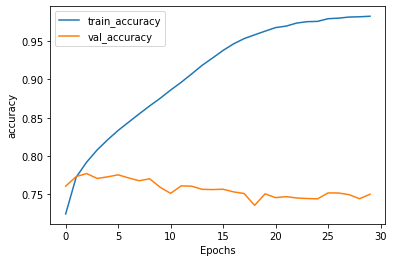

In [ ]:
plot_graphs(history3, "accuracy")

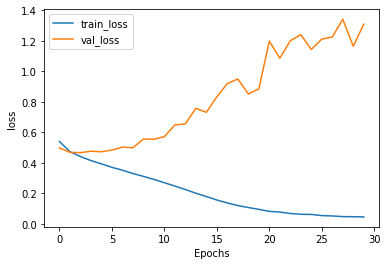

In [ ]:
plot_graphs(history3, "loss")

**So now we clearly overfitted as expected. From now try regularizing, train on entire data and callbacks to improve Validation metrics.**

model 4

In [31]:
tf.keras.backend.clear_session()
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, emb_dimension, input_length=inp_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
BATCH_SIZE = 1024

In [47]:
STEPS_PER_EPOCH = train_inp.shape[0]//BATCH_SIZE

In [48]:
STEPS_PER_EPOCH

1406

In [49]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*10,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [50]:
opt = get_optimizer()

In [51]:
model4.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           64394100  
_________________________________________________________________
dropout (Dropout)            (None, 64, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 512)           788480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 128)           1

In [52]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [53]:
cb = [es]

In [55]:
history4 = model4.fit(train_inp, train_labels, batch_size=BATCH_SIZE, epochs=15, validation_data=(val_inp, val_labels), callbacks=cb)

Epoch 1/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4465 - accuracy: 0.7904 - val_loss: 0.4275 - val_accuracy: 0.8003
Epoch 2/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4381 - accuracy: 0.7951 - val_loss: 0.4212 - val_accuracy: 0.8050
Epoch 3/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4320 - accuracy: 0.7988 - val_loss: 0.4179 - val_accuracy: 0.8066
Epoch 4/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4264 - accuracy: 0.8021 - val_loss: 0.4147 - val_accuracy: 0.8074
Epoch 5/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4217 - accuracy: 0.8045 - val_loss: 0.4147 - val_accuracy: 0.8100
Epoch 6/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4169 - accuracy: 0.8075 - val_loss: 0.4117 - val_accuracy: 0.8100
Epoch 7/15
1407/1407 [==============================] - 120s 85ms/step - loss: 0.4127 - accuracy: 0.8098 - val_loss: 0

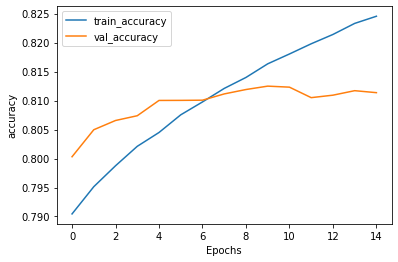

In [56]:
plot_graphs(history4, "accuracy")

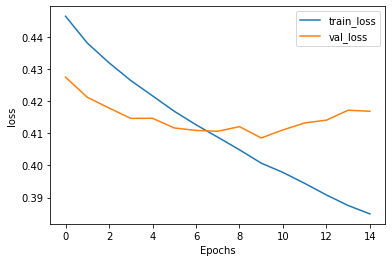

In [57]:
plot_graphs(history4, "loss")

**Decent if not great..**